Based on:
- https://www.kaggle.com/leandrovrabelo/climate-change-forecast-sarima-model
- https://www.kaggle.com/amelinvladislav/map-of-temperatures-and-analysis-of-global-warming/data#1-Mapping-of-average-temperatures-in-the-countries
- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# Global Earth Temperatures -SARIMA model-

In [1]:
# The basic ones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

# Datetime
import datetime

# Some math resources
import math
from math import sqrt
from sklearn.metrics import mean_squared_error

# Remove annoying warnings
import warnings
warnings.filterwarnings('ignore')

# Statsmodel stuff
import statsmodels.tsa.api as tsa # tsa means time-series analysis
from statsmodels.tsa.api import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Plots size and style
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (15,10)

In [3]:
# Import csv

'''This dataset contains the land average temperatures from 1750 to 2015. Also contains land and 
ocean average temperatures, min, max and uncertainity, but on this occasion I am going to focus 
just in the land average temperature and build a SARIMA model with it'''

temperature = pd.read_csv("Temperature/GlobalTemperatures.csv")

In [4]:
temperature.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


# 1 - Initial Data Exploration

In [5]:
# Check the number of rows and columns of the dataset

temperature.shape

(3192, 9)

In [6]:
# Check the data types of the dataset

temperature.dtypes

dt                                            object
LandAverageTemperature                       float64
LandAverageTemperatureUncertainty            float64
LandMaxTemperature                           float64
LandMaxTemperatureUncertainty                float64
LandMinTemperature                           float64
LandMinTemperatureUncertainty                float64
LandAndOceanAverageTemperature               float64
LandAndOceanAverageTemperatureUncertainty    float64
dtype: object

In [7]:
# Print a concise summary of the dataset

temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


In [8]:
# Check the number of nulls

temperature.isnull().sum()

dt                                              0
LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

In [9]:
# Check some basic statistics

temperature.describe()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
count,3180.000000,3180.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000
mean,8.374731,0.938468,14.350601,0.479782,2.743595,0.431849,15.212566,0.128532
std,4.381310,1.096440,4.309579,0.583203,4.155835,0.445838,1.274093,0.073587
min,-2.080000,0.034000,5.900000,0.044000,-5.407000,0.045000,12.475000,0.042000
25%,4.312000,0.186750,10.212000,0.142000,-1.334500,0.155000,14.047000,0.063000
50%,8.610500,0.392000,14.760000,0.252000,2.949500,0.279000,15.251000,0.122000
75%,12.548250,1.419250,18.451500,0.539000,6.778750,0.458250,16.396250,0.151000
max,19.021000,7.880000,21.320000,4.373000,9.715000,3.498000,17.611000,0.457000


# 2 - Cleaning dataset

In [10]:
# Change dt object to dt datetime64[ns]

temperature['dt'] = pd.to_datetime(temperature['dt'], format = '%Y-%m-%d')

In [11]:
# Set date in the index of the dataset

temperature.set_index('dt', inplace=True)
temperature.sort_index(inplace=True)

In [12]:
# Remove NaN values

clean_temp = temperature.dropna()

In [13]:
# Clean dataset from 1850 after removing rows with NaN, the data before that is very old data with high uncertanity

clean_temp

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249
...,...,...,...,...,...,...,...,...
2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062


# 3 - Exploratory Data Analysis


Text(0, 0.5, 'Temperature (C)')

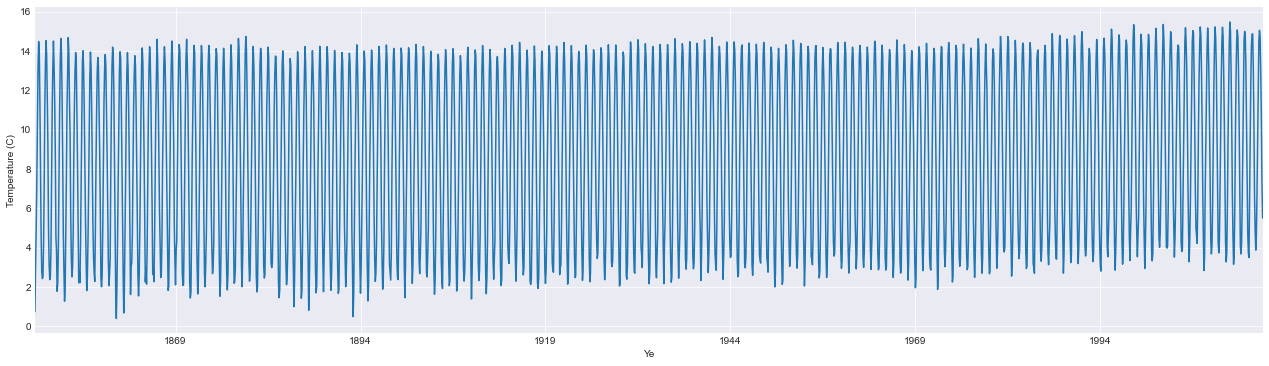

In [14]:
# Plot the Land average temperature over time

plt.figure(figsize=(22,6))
clean_temp['LandAverageTemperature'].plot()
plt.xlabel("Ye")
plt.ylabel("Temperature (C)")
### It is hard to see anything here. That's because there's lots of data and strong seasonality.

In [15]:
# define a function that splits a chosen column by year and month

def get_ploteable_table(df, colname):
    ploteable = df.loc[:, [colname] ] # Selecting columns with a list returns a Pandas Dataframe
    ploteable["year"] = df.index.year
    ploteable["month"] = df.index.month
    
    return(ploteable)


In [16]:
# Check the function works with LandAverageTemperature

get_ploteable_table(clean_temp, 'LandAverageTemperature')

,LandAverageTemperature,year,month
dt,,,
1850-01-01,0.749,1850,1
1850-02-01,3.071,1850,2
1850-03-01,4.954,1850,3
1850-04-01,7.217,1850,4
1850-05-01,10.004,1850,5
...,...,...,...
2015-08-01,14.755,2015,8
2015-09-01,12.999,2015,9
2015-10-01,10.801,2015,10


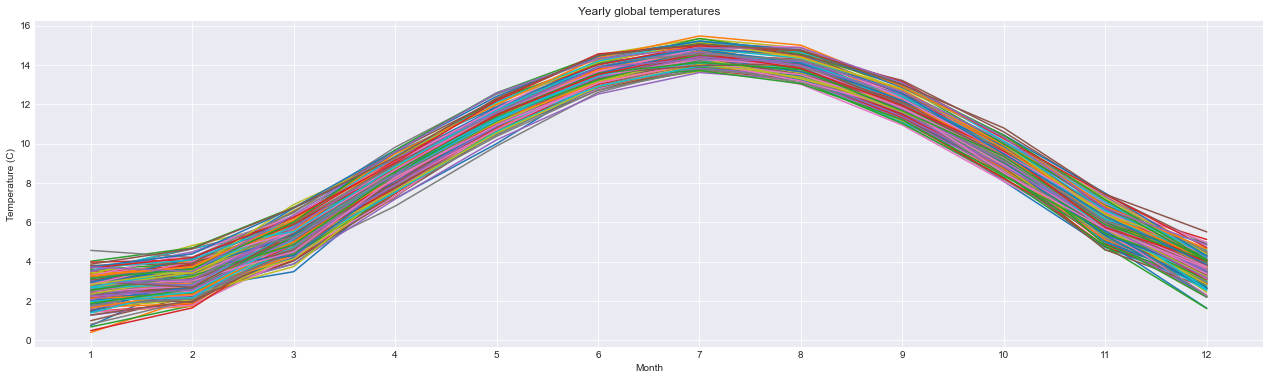

'Here we can see the seasonality. The cause of the seasonality\n   there is variation of the temperature throughout the year'

In [17]:
# Plot the yearly global temperatures

global_month = get_ploteable_table(clean_temp, "LandAverageTemperature")

## Change year and temperature position in the table using pivot_table function

pivoted_global_month = pd.pivot_table(global_month, 
                                      values="LandAverageTemperature",
                                      index="month", 
                                      columns = "year", 
                                      aggfunc="mean")
pivoted_global_month.plot(figsize=(22,6))
plt.title("Yearly global temperatures")
plt.xlabel("Month")
plt.ylabel("Temperature (C)")
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

'''Here we can see the seasonality. The cause of the seasonality
   there is variation of the temperature throughout the year'''

In [18]:
# Check pivoted table

pivoted_global_month

year,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
month,,,,,,,,,,,,,,,,,,,,,
1,0.749,2.431,2.376,1.786,1.281,2.522,2.760,1.821,2.739,2.015,...,3.286,4.579,2.844,3.687,3.737,3.282,3.157,3.685,3.732,3.881
2,3.071,2.508,2.540,2.228,1.941,2.982,2.226,2.481,2.284,2.611,...,4.430,4.221,3.576,4.094,4.399,3.743,3.628,4.222,3.500,4.664
3,4.954,4.192,3.884,4.078,4.698,4.617,4.372,4.312,4.834,5.023,...,6.329,6.485,6.906,6.086,6.738,6.101,6.023,6.261,6.378,6.740
4,7.217,7.287,7.487,7.541,7.622,8.580,7.751,6.827,8.250,8.542,...,9.055,9.823,9.295,9.367,9.671,9.483,9.676,9.044,9.589,9.313
5,10.004,11.113,11.169,10.975,11.095,11.186,10.530,9.885,10.851,11.456,...,11.786,12.518,12.054,12.112,12.406,11.986,12.590,12.195,12.582,12.312
6,13.150,13.418,13.164,13.410,12.829,12.984,13.496,12.611,12.956,13.142,...,14.443,14.309,14.145,14.201,14.421,14.370,14.492,14.568,14.335,14.505
7,14.492,14.531,14.512,14.645,14.692,13.926,14.019,13.953,13.677,13.827,...,15.042,15.230,15.174,15.231,15.213,15.482,15.076,15.003,14.873,15.051
8,14.039,13.751,13.304,13.953,13.889,13.547,13.021,13.203,13.220,13.217,...,14.913,14.752,14.377,14.655,14.768,15.012,14.720,14.742,14.875,14.755
9,11.505,11.677,11.478,11.710,11.514,11.141,10.948,11.056,11.148,11.080,...,12.875,12.930,12.802,13.153,12.863,12.912,13.040,13.154,13.091,12.999


---

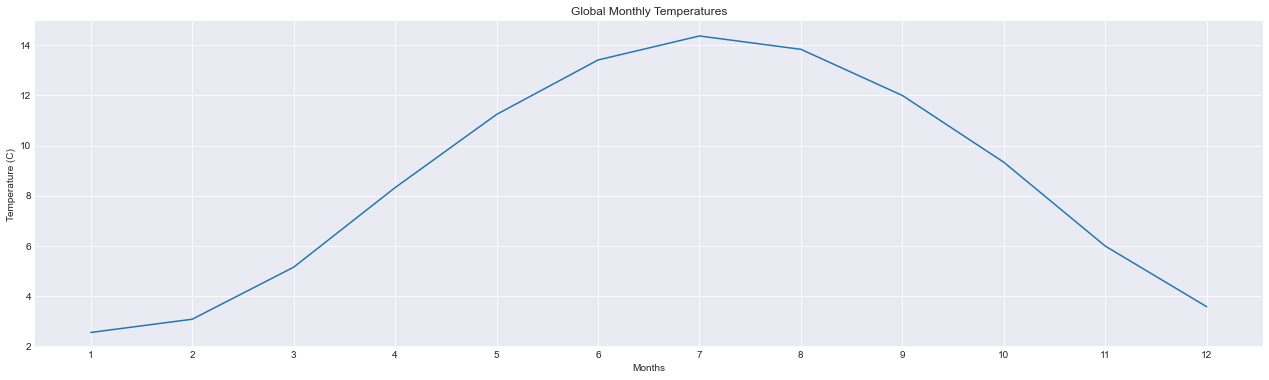

In [19]:
# I can show this with the monthly average across all years, maybe it is easier to see:
monthly_pivot = pivoted_global_month.mean(axis=1) # Axis = 1 means rows 

## Plotting
monthly_pivot.plot(figsize=(22,6))
plt.title('Global Monthly Temperatures')
plt.xlabel('Months')
plt.ylabel('Temperature (C)')
plt.xticks([x for x in range(1,13)])
plt.show()


### 3.1 - Temperatures in each season over time

In [20]:
clean_temp['month']=clean_temp.index.month

In [21]:
# Defining a function to get the 4 seasons of the year

def get_season(month):
    if month>=3 and month<=5:
        return 'spring'
    elif month>=6 and month<=8:
        return 'summer'
    elif month>=9 and month<=11:
        return 'autumn'
    else:
        return 'winter'

In [22]:
clean_temp['season']=clean_temp['month'].apply(get_season)

In [23]:
clean_temp.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,month,season
dt,,,,,,,,,,
1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367,1,winter
1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414,2,winter
1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341,3,spring
1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267,4,spring
1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249,5,spring


In [24]:
# Create a variable to get the year from the index

years = clean_temp.index.year

In [25]:
# Create 'years' column

clean_temp['years'] = clean_temp.index.year

In [26]:
# Check the columns if the dataset

clean_temp.columns

Index(['LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty', 'month', 'season',
       'years'],
      dtype='object')

In [30]:
# Create 4 season empty lists. The for loop will add to the list each the mean temperature according to the season, per year

spring_temp = []
summer_temp = []
autumn_temp = []
winter_temp = []

for year in years:
    current_temp=clean_temp[clean_temp['years'] == year]
    spring_temp.append(current_temp[clean_temp['season'] == 'spring']['LandAverageTemperature'].mean())
    summer_temp.append(current_temp[clean_temp['season'] == 'summer']['LandAverageTemperature'].mean())
    autumn_temp.append(current_temp[clean_temp['season'] == 'autumn']['LandAverageTemperature'].mean())
    winter_temp.append(current_temp[clean_temp['season'] == 'winter']['LandAverageTemperature'].mean())

In [31]:
season = pd.DataFrame()

In [32]:
season.index = clean_temp.index

ValueError: Length mismatch: Expected axis has 0 elements, new values have 1992 elements

In [180]:
season['year'] = years
season['Spring'] = spring_temp
season['Summer'] = summer_temp
season['Autumn'] = autumn_temp
season['Winter'] = winter_temp

In [181]:
season.head()

,year,spring_temp,summer_temp,autumn_temp,winter_temp,Spring,Summer,Autumn,Winter
dt,,,,,,,,,
1850-01-01,1850,7.391667,13.893667,8.109667,2.207667,7.391667,13.893667,8.109667,2.207667
1850-02-01,1850,7.391667,13.893667,8.109667,2.207667,7.391667,13.893667,8.109667,2.207667
1850-03-01,1850,7.391667,13.893667,8.109667,2.207667,7.391667,13.893667,8.109667,2.207667
1850-04-01,1850,7.391667,13.893667,8.109667,2.207667,7.391667,13.893667,8.109667,2.207667
1850-05-01,1850,7.391667,13.893667,8.109667,2.207667,7.391667,13.893667,8.109667,2.207667


In [296]:
fig=px.line(season.resample('Y').mean(), y=['Spring','Summer','Autumn','Winter'],
            title='Avg.temperature in each season',
            width= 600,
            height= 600,
            labels = {'variable': '',
                      'value':'temperature (Celsius)',
                      'dt':'Year'},
           color_discrete_map = {'Spring':'springgreen',
                                 'Summer':'indianred', 
                                 'Autumn':'goldenrod', 
                                 'Winter':'royalblue'})

fig.show()

---
###  3.2 - Finding Trends


In [33]:
def plot_tsa_and_mean(df, colname, timeperiod ,rollingnum):
   
    '''Function takes a column from the dataframe, resamples it per timeperiod and plot its
    values and the moving average with the rollingnum moving average''' 
   
    dfCol = df.loc[:, [colname] ].resample(timeperiod).mean()
       
   
    fig, ax = plt.subplots()
    ax.plot(dfCol, label="Annual Global Temperature")
    ax.plot(dfCol.rolling(rollingnum).mean(), label=f'{rollingnum} years MA')
    ax.legend()
    plt.title('Global Average Temperatures')
    plt.xlabel('Years')
    plt.ylabel('Temperature (C)')

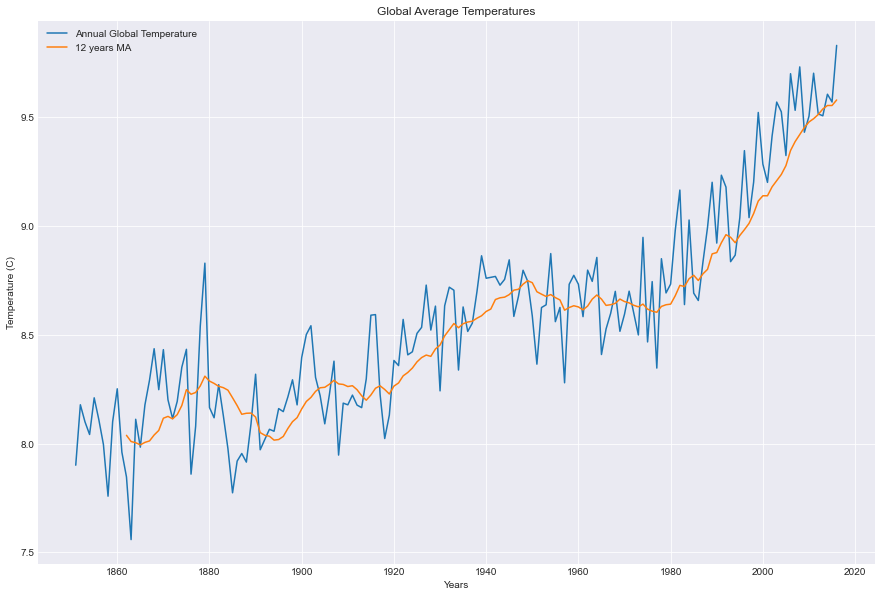

In [34]:
plot_tsa_and_mean(clean_temp, "LandAverageTemperature", "Y", 12) 
# There is trend and seasonality, but to perform ARIMA/SARIMA we need to make the data stationary.

## 3.3 - Evaluating stationarity

In [35]:
# Drop created columns to avoid future errors:
clean_temp = clean_temp.drop(columns = ['season', 'month', 'years'])


In [36]:
# Dickey-Fuller test:
# To check is it is stationary (p <= 0.05)

from statsmodels.tsa.stattools import adfuller
X = clean_temp['LandAverageTemperature']
result = adfuller(X)

In [37]:
# No diff:
print('ADF Statistic: %f' % result[0]) # Non stationary, we accept the null hypothesis (H0)
print('p-value: %f' % result[1]) # p-value very high.

ADF Statistic: -1.455328
p-value: 0.555483


In [38]:
clean_temp.diff()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1850-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-02-01,2.322,0.170,1.728,1.269,0.915,-1.199,0.755,0.047
1850-03-01,1.883,-0.320,0.377,-0.606,0.386,-0.213,0.455,-0.073
1850-04-01,2.263,-0.290,2.587,-1.397,2.923,-0.081,0.624,-0.074
1850-05-01,2.787,-0.048,2.721,1.402,2.793,0.018,0.840,-0.018
...,...,...,...,...,...,...,...,...
2015-08-01,-0.296,-0.014,-0.205,0.001,-0.321,-0.055,-0.022,-0.001
2015-09-01,-1.756,0.007,-1.854,-0.022,-1.806,0.059,-0.540,0.001
2015-10-01,-2.198,0.023,-2.395,-0.029,-1.967,-0.114,-0.759,0.004


In [39]:
# remove missing value first row:
clean_temp.diff()['LandAverageTemperature'][1:].head()

dt
1850-02-01    2.322
1850-03-01    1.883
1850-04-01    2.263
1850-05-01    2.787
1850-06-01    3.146
Name: LandAverageTemperature, dtype: float64

In [40]:
# 1 lag differencing and check if it's stationary (p<= 0.05)
X = clean_temp.diff()['LandAverageTemperature'][1:]
result = adfuller(X)

In [41]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) 
# p-value is very significative. It is stationary with 1st Order diff, d=1. Now it is possible to perform SARIMA.

ADF Statistic: -12.581647
p-value: 0.000000


---
# 4 - SARIMA Model of global land temperatures


### 4.1 - ACF, PACF and seasional decomposition

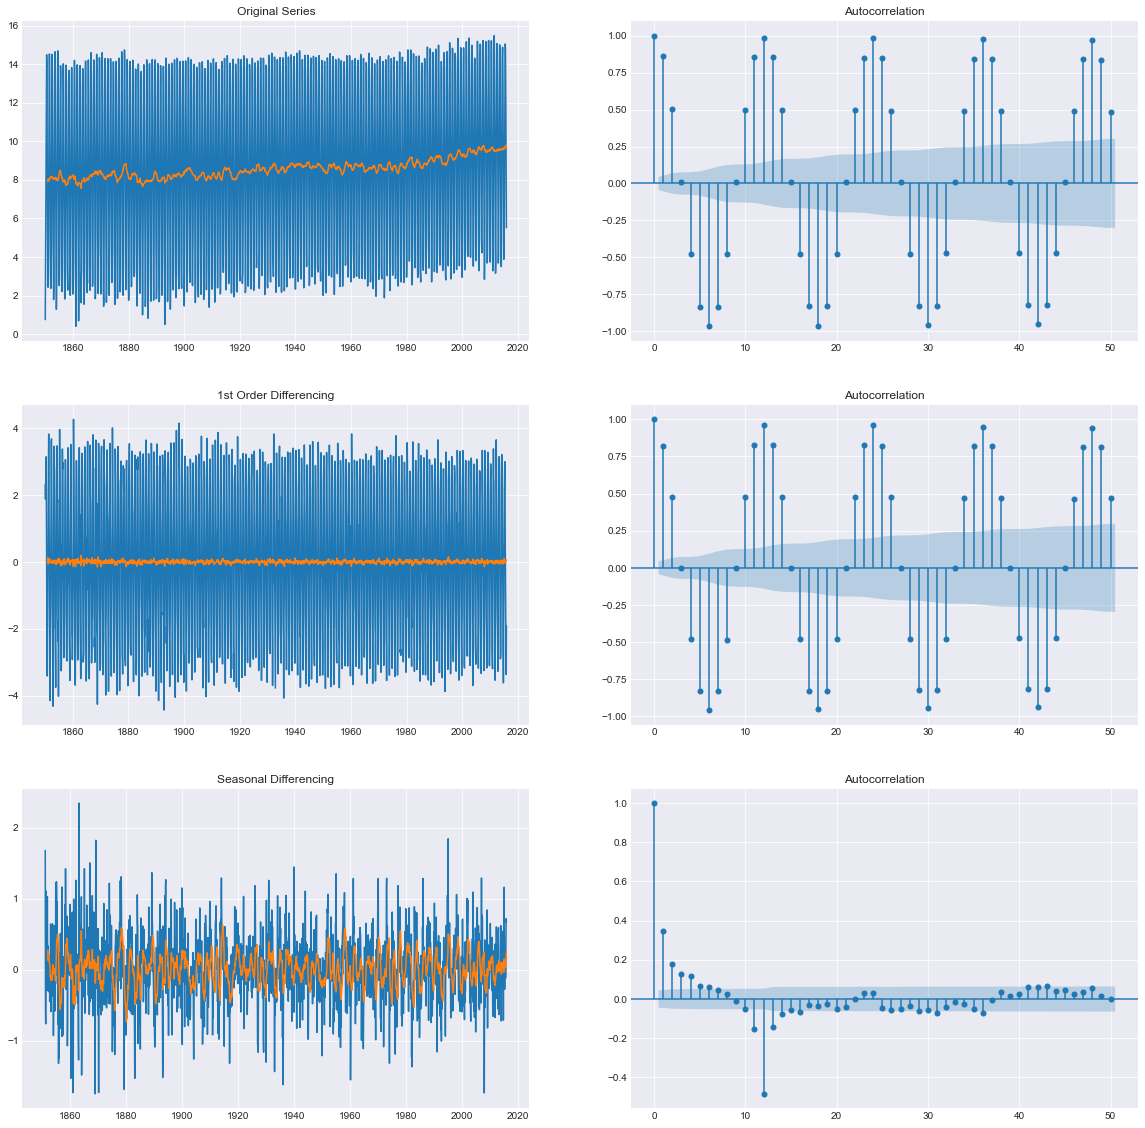

In [42]:
# ACF to find the ARIMA's d and SARIMA's D value. Plot the orgininal series vs 1st Order Differencing and Seasonal Differencing

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(20,20))
axes[0, 0].plot(clean_temp["LandAverageTemperature"]); axes[0, 0].set_title('Original Series')
axes[0, 0].plot(clean_temp["LandAverageTemperature"].rolling(12).mean())
plot_acf(clean_temp["LandAverageTemperature"], ax=axes[0, 1], lags=50)

# 1st Differencing
axes[1, 0].plot(clean_temp["LandAverageTemperature"].diff(1)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(clean_temp["LandAverageTemperature"].diff(1).dropna(), lags=50, ax=axes[1, 1])
axes[1, 0].plot(clean_temp["LandAverageTemperature"].diff(1).rolling(12).mean())

# Seasonal Differencing
axes[2, 0].plot(clean_temp["LandAverageTemperature"].diff(12)); axes[2, 0].set_title('Seasonal Differencing')
plot_acf(clean_temp["LandAverageTemperature"].diff(12).dropna(), ax=axes[2, 1], lags=50)
axes[2, 0].plot(clean_temp["LandAverageTemperature"].diff(12).rolling(12).mean())

plt.show()

#I'm going to get the first order differencing, we can see that with d=1 is stationary, but we can see the effect
#of seasonality. With d=12 we remove seasonality, therefore SARIMA's s parameter is 12

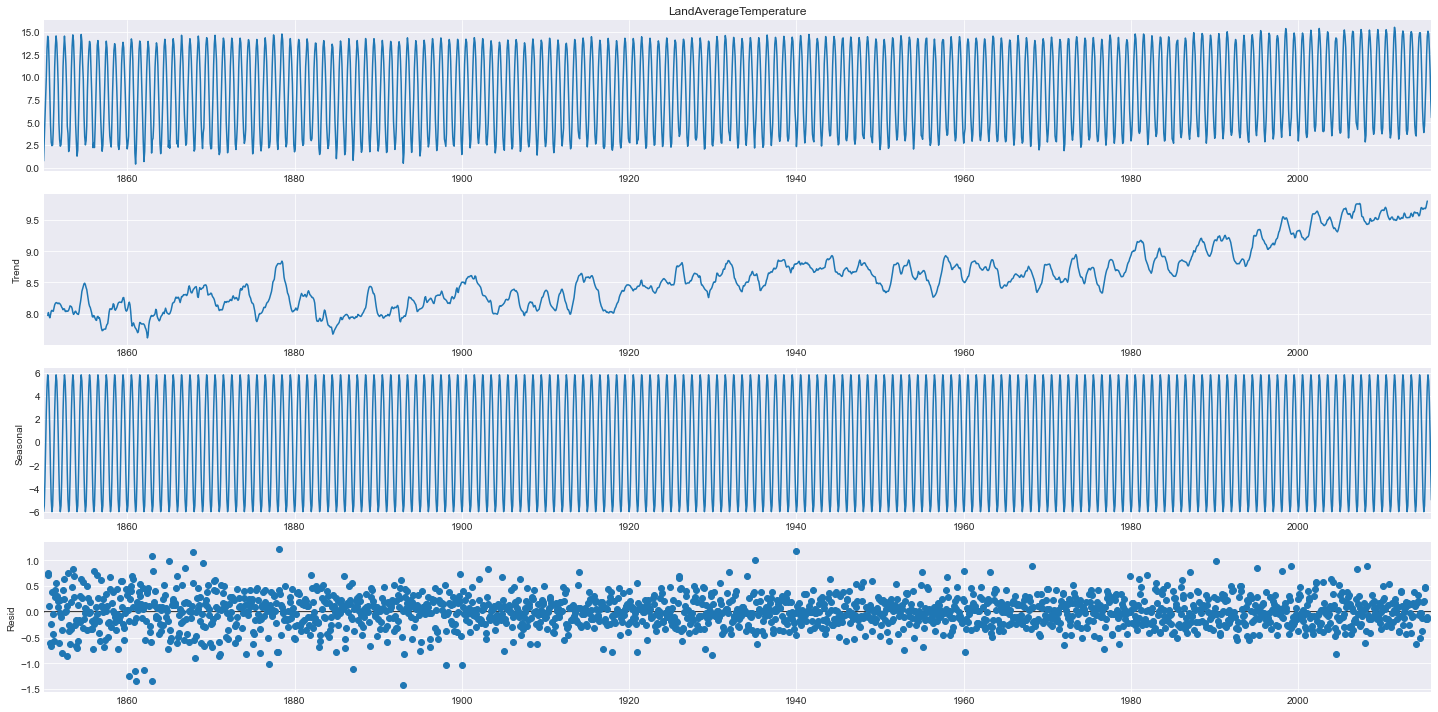

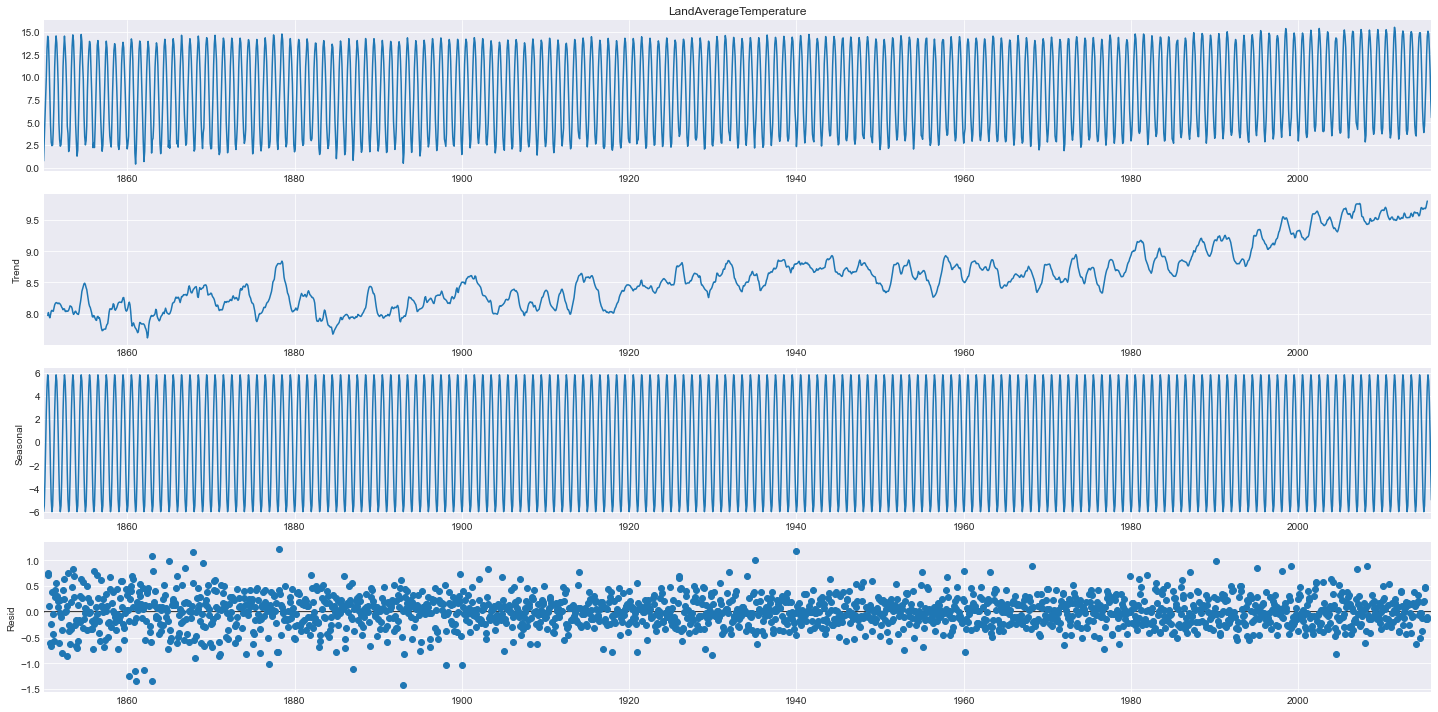

In [71]:
#Additive seasonal decomposition. We can observe a time series increasing trend
   #and some random noise and decompose it as an additive model.

result = tsa.seasonal_decompose(clean_temp["LandAverageTemperature"])
result.plot()

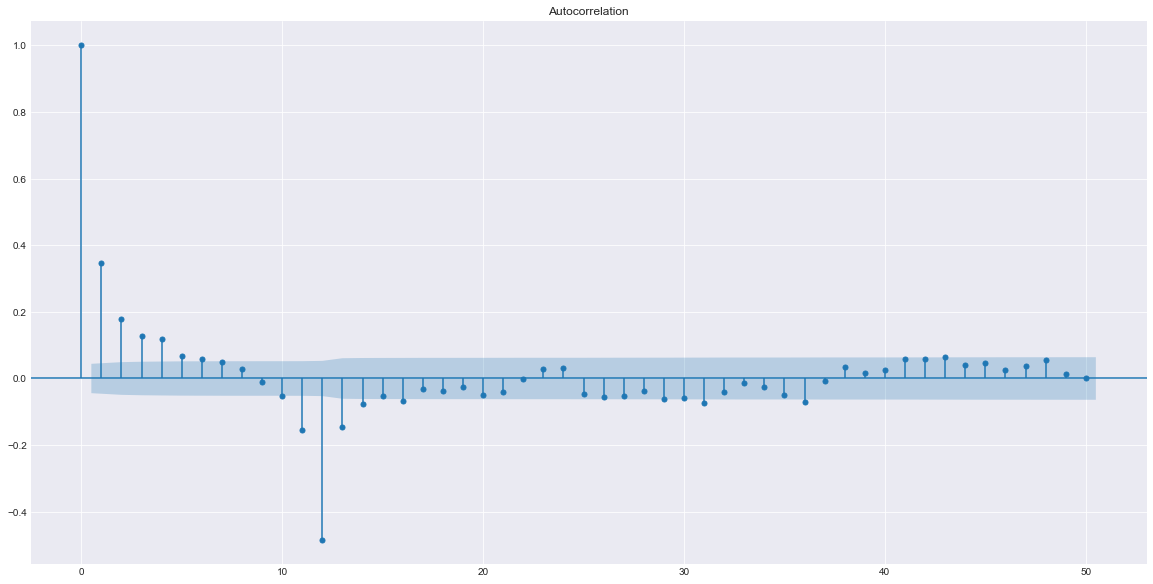

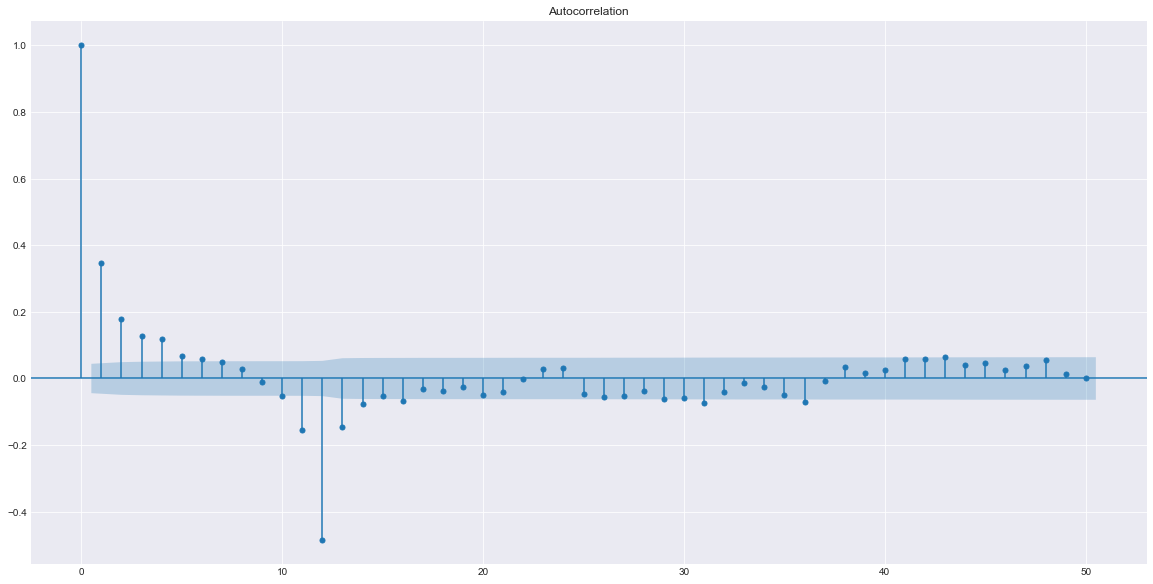

In [65]:
# Plot the autocorrelation, to get the AR (p=1)

plot_acf(clean_temp["LandAverageTemperature"].diff(12).dropna(), lags=50)

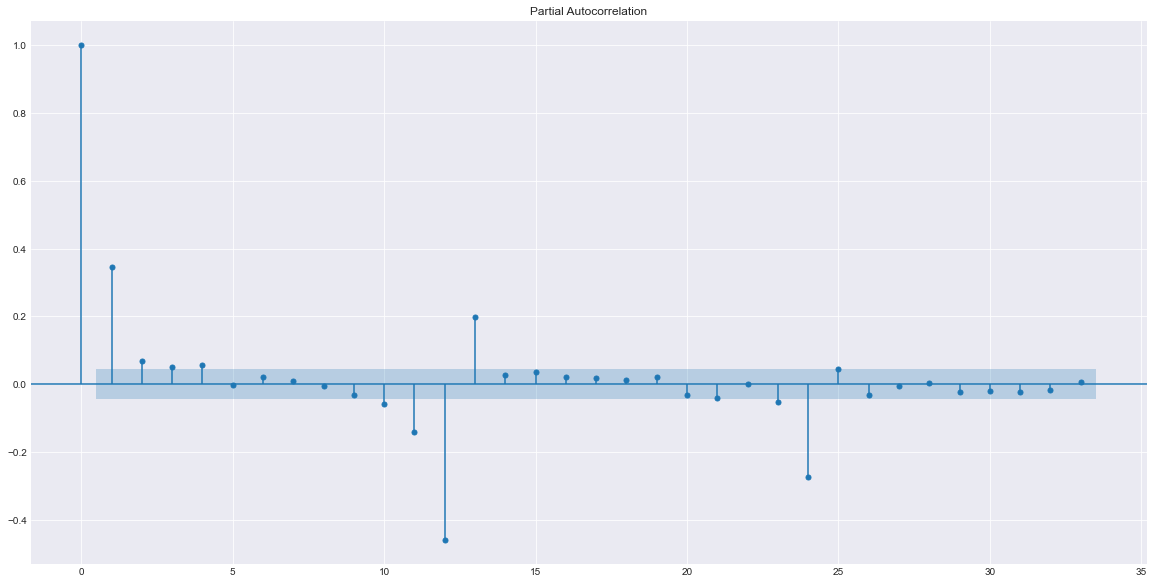

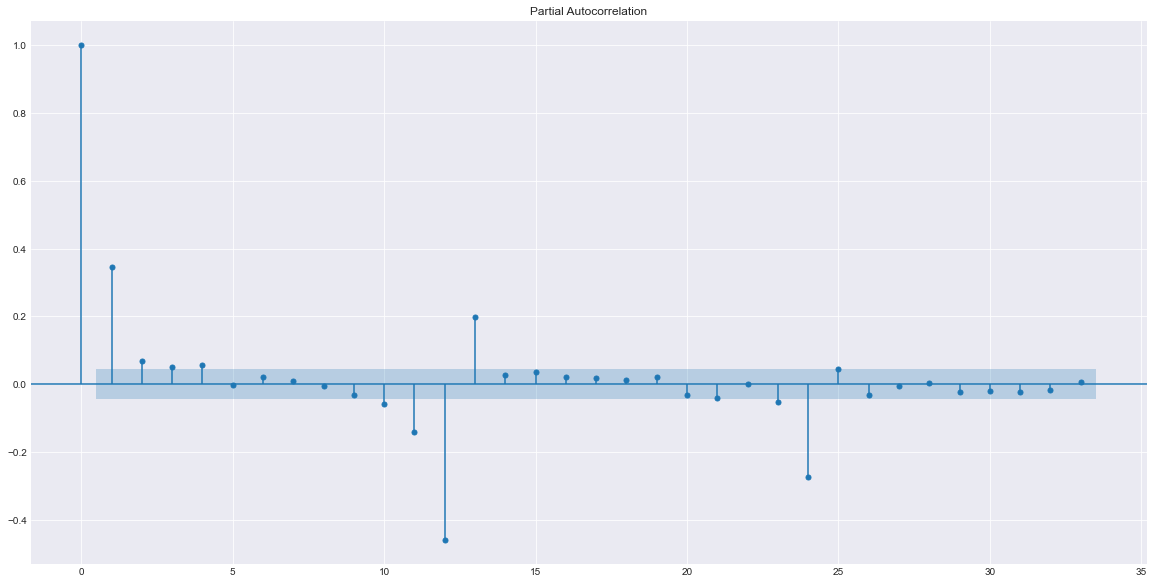

In [66]:
# Plot the partial autocorrelation with 1st Order Difference to get the MA order (q = 1)

plot_pacf(clean_temp["LandAverageTemperature"].diff(12).dropna())

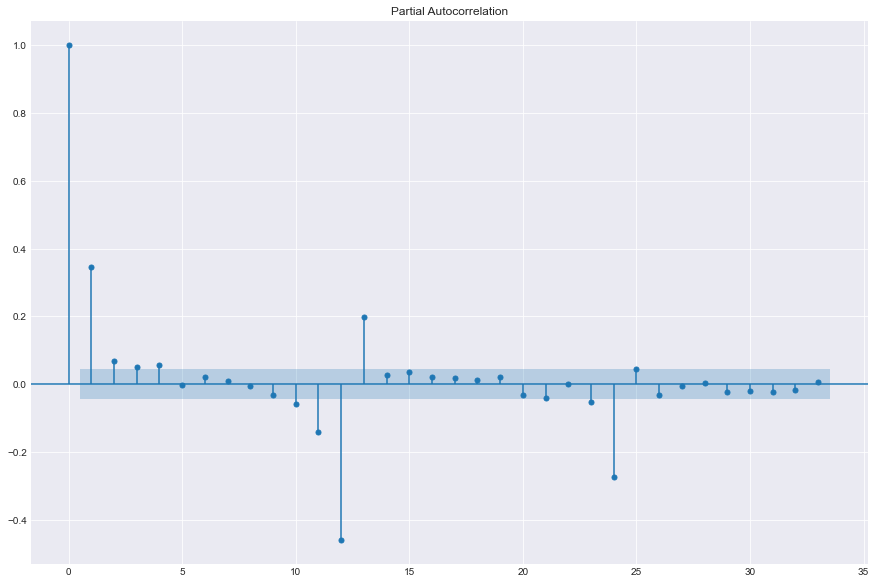

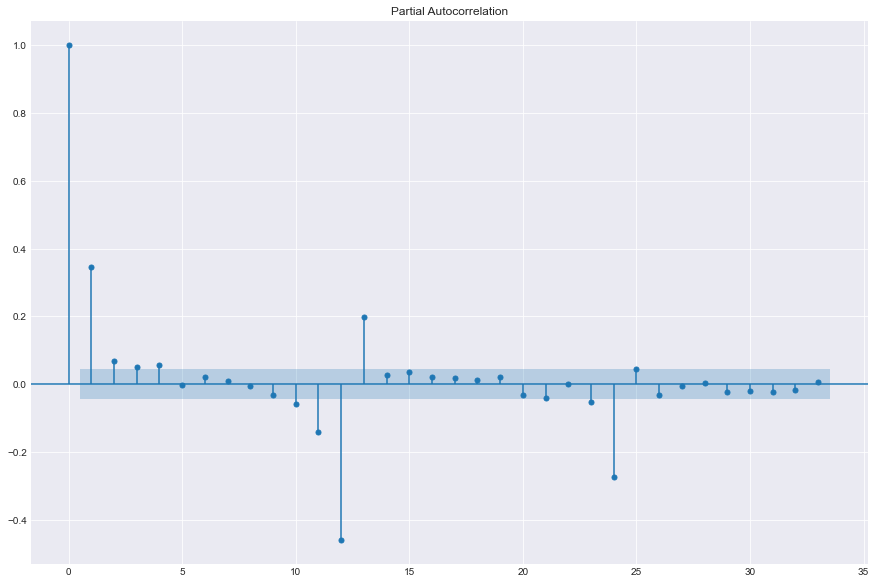

In [78]:
# PACF with seasonal differencing D=1

plot_pacf(clean_temp["LandAverageTemperature"].diff(12).dropna())

### 4.2 - SARIMA Model

- https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide
- https://www.wisdomgeek.com/development/machine-learning/sarima-forecast-seasonal-data-using-python/
- https://otexts.com/fpp2/seasonal-arima.html
- https://stats.stackexchange.com/questions/445014/how-to-set-p-d-q-and-p-d-q-for-sarima-time-series-model

Very nice flowchart:

- https://autobox.com/pdfs/ARIMA%20FLOW%20CHART.pdf


In [43]:
# Build the SARIMA model

model = tsa.SARIMAX(endog= clean_temp["LandAverageTemperature"], order = (1,1,3), 
                    seasonal_order = (0,1,1,12))


C:\Users\npfer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\npfer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [44]:
# Fit the SARIMA model and print summary of the results

fitted_model3 = model.fit()
fitted_model3.summary()

# I tried different values but I have chosen the ones with the most significant values and lowest AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:               LandAverageTemperature   No. Observations:                 1992
Model:             SARIMAX(1, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -635.708
Date:                              Wed, 27 Oct 2021   AIC                           1283.416
Time:                                      13:06:44   BIC                           1316.958
Sample:                                  01-01-1850   HQIC                          1295.738
                                       - 12-01-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8489      0.046     18.565      0.000       0.759       0.939
ma.L1         -1.5155      0.051    -29.620      0.000      -1.616      -1.415
ma.L2          0.4020      0.042      9.641      0.000       0.320       0.484
ma.L3          0.1182      0.028      4.196      0.000       0.063       0.173
ma.S.L12      -0.9494      0.008   -113.864      0.000      -0.966      -0.933
sigma2         0.1095      0.003     43.235      0.000       0.105       0.114
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):               301.01
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

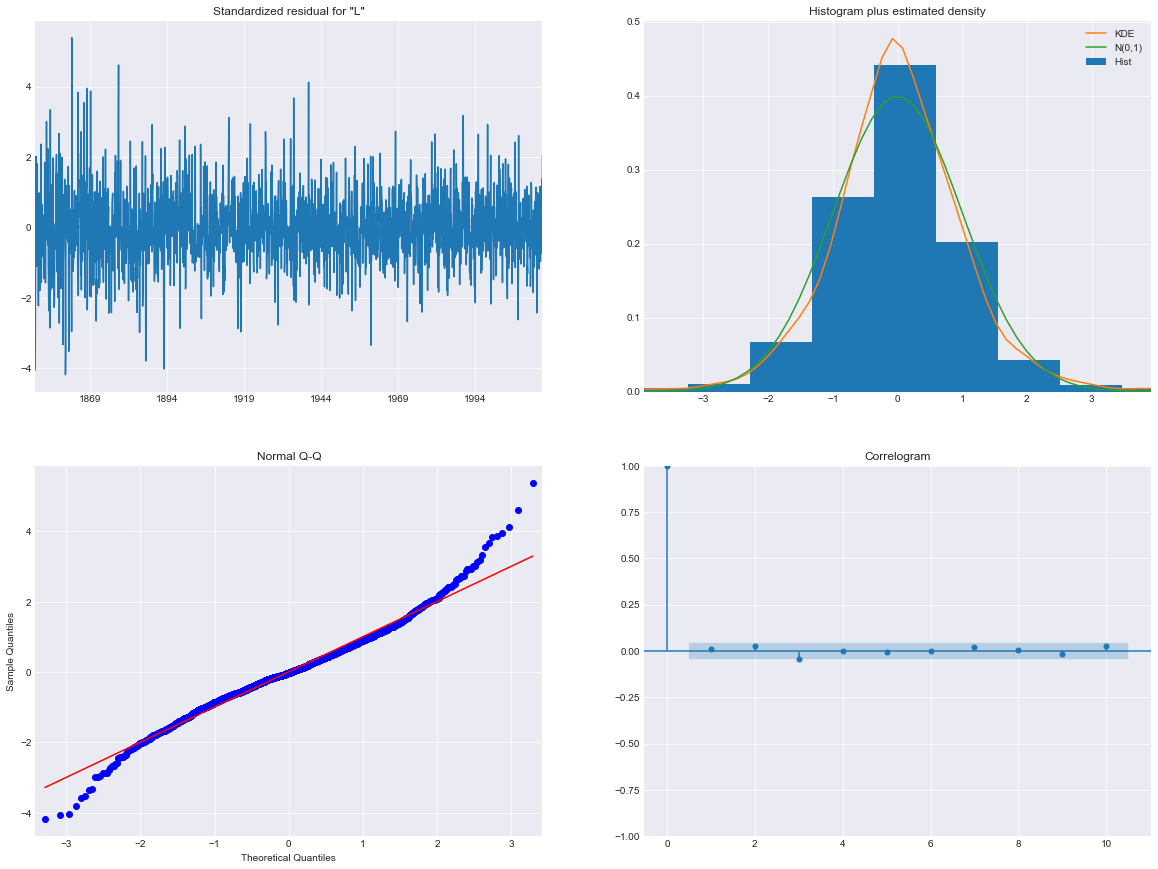

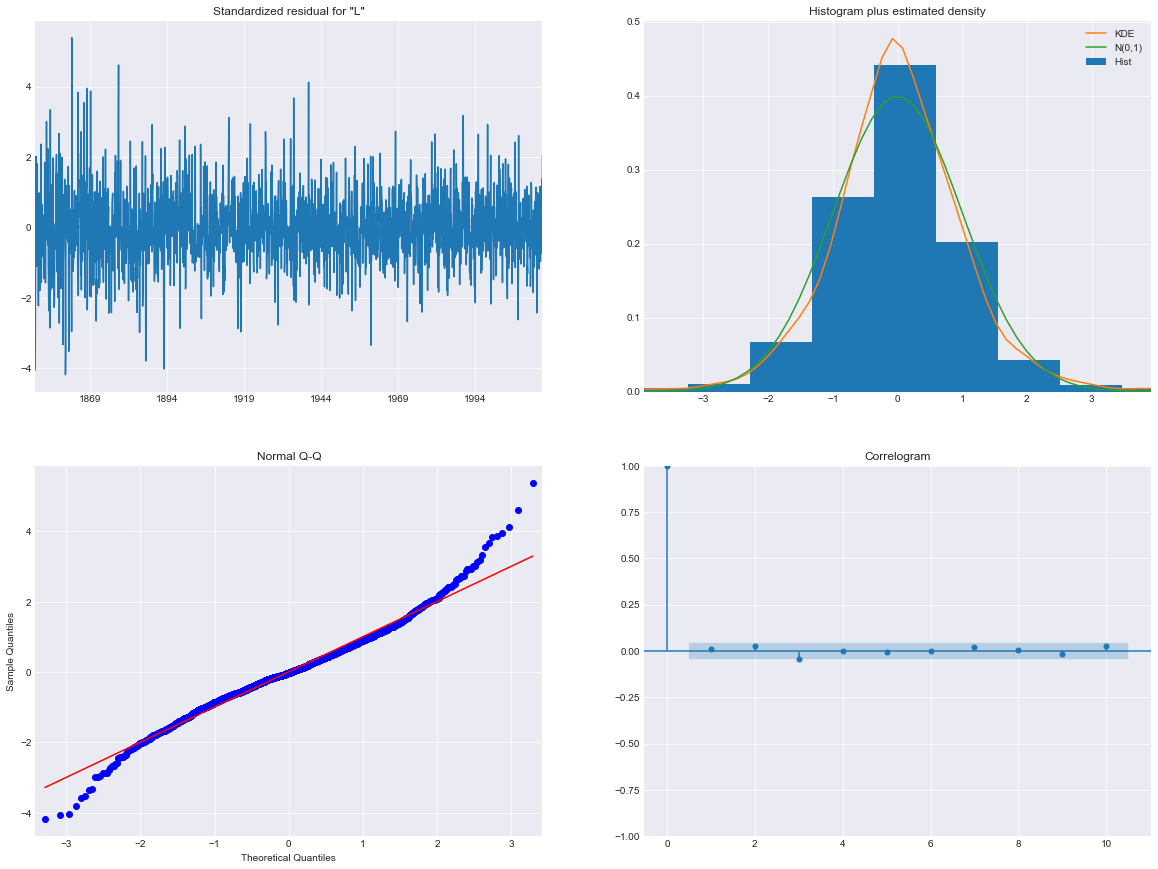

In [45]:
# Plot diagnostics
fitted_model3.plot_diagnostics(figsize=(20,15))

# Residuals have a normal distribution
# Residuals should have mean 0 and constant variance. Also, 0 correlation.

### 4.3 - Comparison of the Fitted model vs Actual temperatures

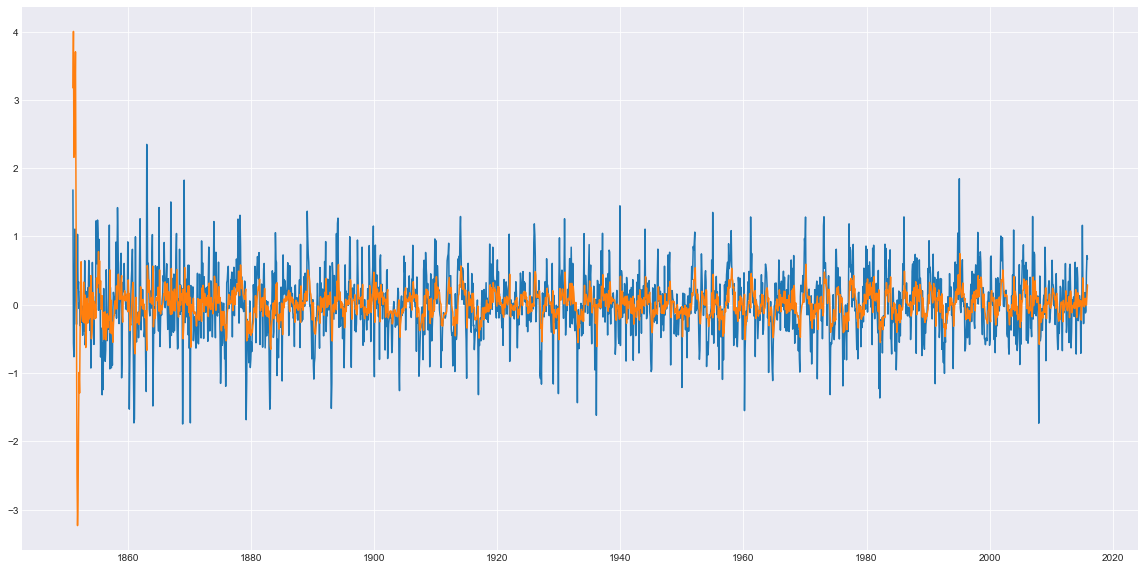

In [46]:
# Actual vs Fitted
fitted_results = fitted_model3.get_prediction(start=clean_temp.index[0])

plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()
ax.plot(clean_temp["LandAverageTemperature"].diff(12))
ax.plot(fitted_results.predicted_mean.diff(12))
    
    
# actual and fitted values without seasonal component   

Text(0, 0.5, 'Temperature (C)')

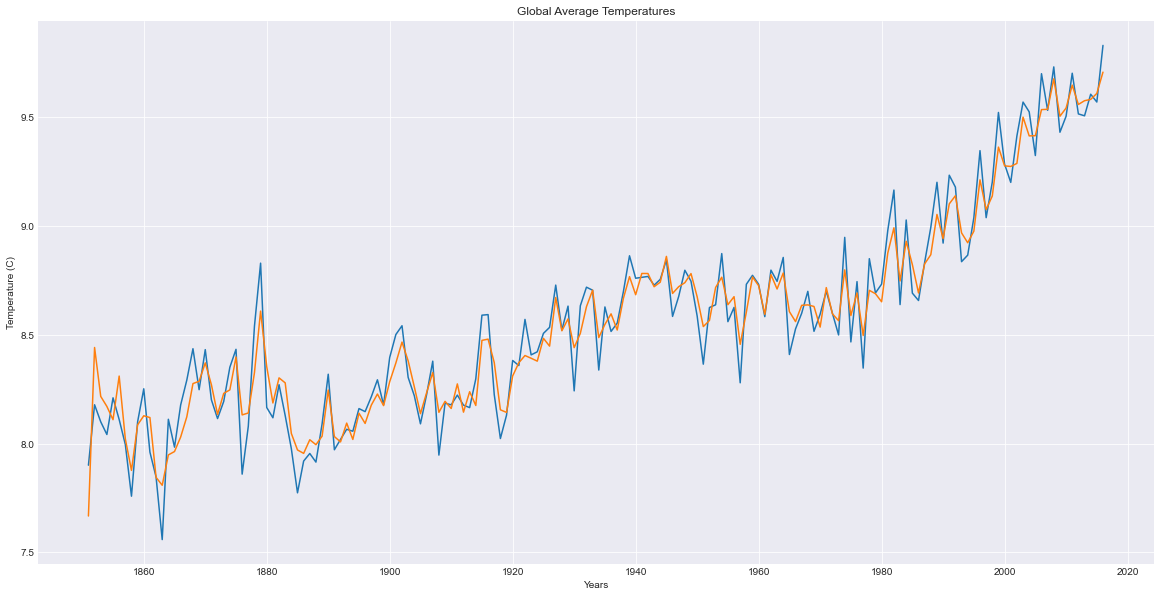

In [47]:
# Plot the actual temperatures vs predicted temperatures resampled by year

fig, ax = plt.subplots()
ax.plot(clean_temp["LandAverageTemperature"].resample('Y').mean()[0:])
ax.plot(fitted_results.predicted_mean.resample('Y').mean()[0:])
plt.title('Global Average Temperatures')
plt.xlabel('Years')
plt.ylabel('Temperature (C)')

# We can see that the model follows a similar trend to the actual temperatures

---
# 5 - Validating the model

### 5.1 - Out-of-Time Cross Validation

#### Train(75%)/Test(25%) split

In [48]:
# train dataset will be until year 2000:

year_train = "2000"

In [49]:
# Create the variables train and test:

train = clean_temp[:year_train] # train dataset from 1980 (huge change in trend from this year)
test = clean_temp[year_train:]

In [50]:
train.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249


In [51]:
test.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
2000-01-01,2.950,0.091,8.349,0.103,-2.322,0.072,13.773,0.064
2000-02-01,4.184,0.093,9.863,0.096,-1.371,0.092,14.266,0.065
2000-03-01,6.219,0.120,12.205,0.133,0.376,0.082,14.846,0.069
2000-04-01,9.552,0.075,15.534,0.156,3.680,0.153,15.762,0.062
2000-05-01,11.874,0.064,17.721,0.127,5.997,0.200,16.395,0.061


### 5.2 - Fitting the model 

In [52]:
# Create the SARIMA model of train

model = tsa.SARIMAX(endog= train["LandAverageTemperature"], order = (1,1,3), 
                    seasonal_order = (0,1,1,12))

fitted_model4 = model.fit()
fitted_model4.summary()

C:\Users\npfer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\npfer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\npfer\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:               LandAverageTemperature   No. Observations:                 1812
Model:             SARIMAX(1, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -597.401
Date:                              Wed, 27 Oct 2021   AIC                           1206.801
Time:                                      13:09:23   BIC                           1239.771
Sample:                                  01-01-1850   HQIC                          1218.972
                                       - 12-01-2000                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8733      0.039     22.326      0.000       0.797       0.950
ma.L1         -1.5353      0.046    -33.684      0.000      -1.625      -1.446
ma.L2          0.4064      0.040     10.043      0.000       0.327       0.486
ma.L3          0.1319      0.028      4.774      0.000       0.078       0.186
ma.S.L12      -0.9461      0.009   -102.996      0.000      -0.964      -0.928
sigma2         0.1117      0.003     41.522      0.000       0.106       0.117
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               299.19
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

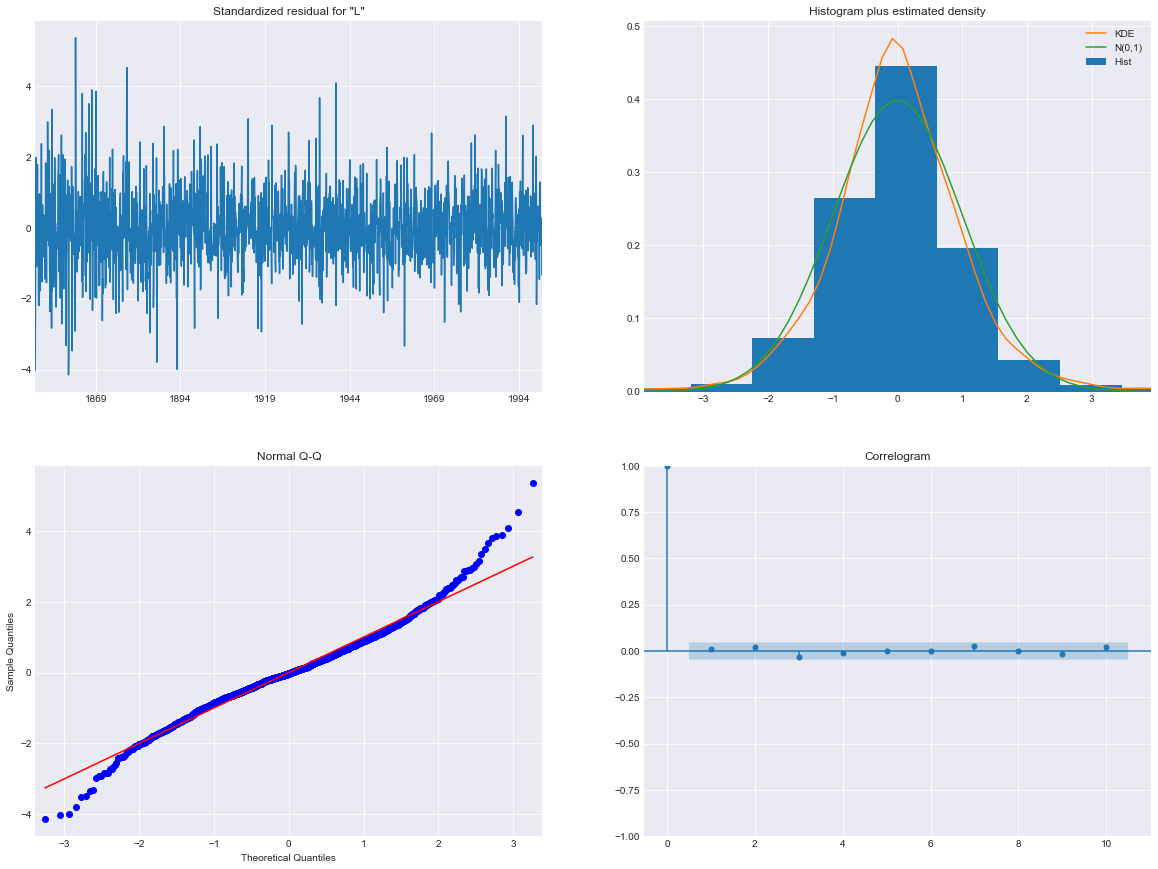

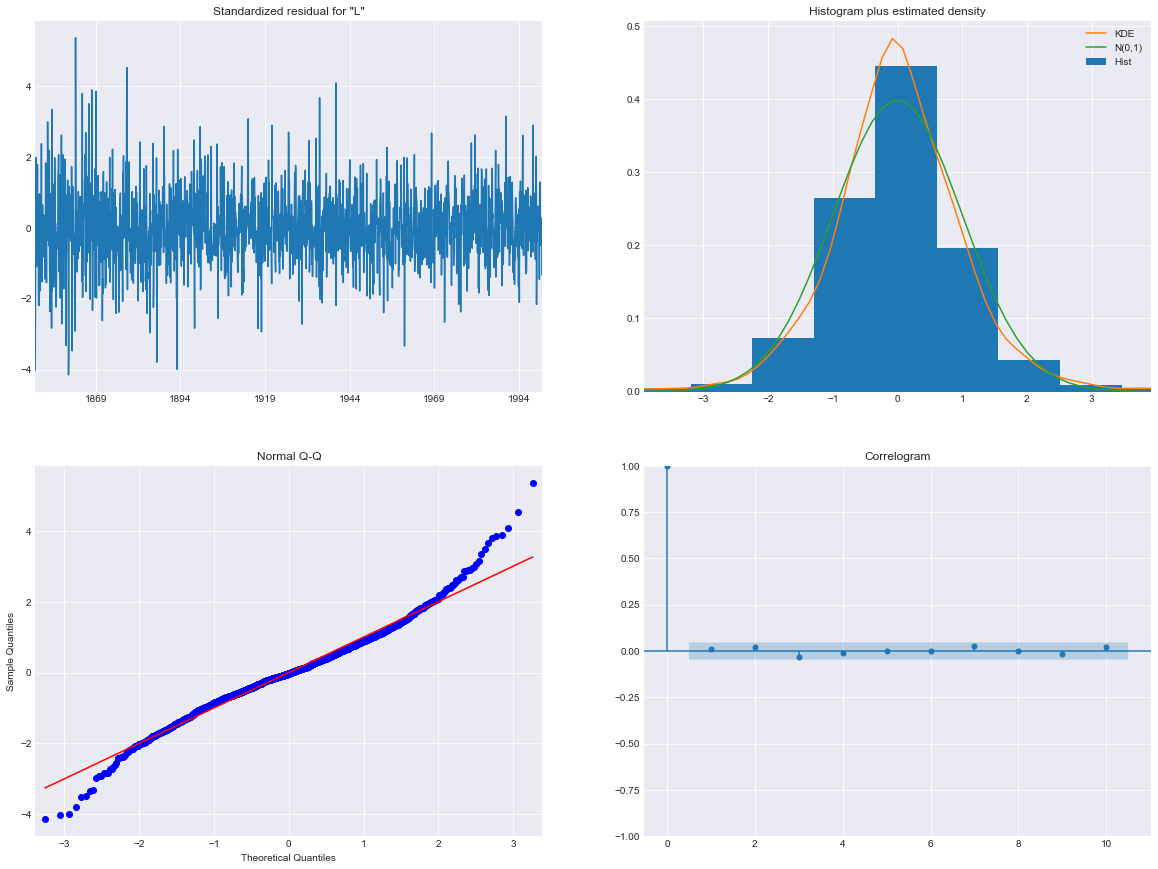

In [240]:
# Plot diagnostics: 

fitted_model4.plot_diagnostics(figsize=(20,15))

### 5.3 - Forecasting test

In [53]:
# test Forecast
n_periods = len(clean_temp) - len(train) + 12


predicted_values = fitted_model4.get_prediction(start=train.index[-12], end=test.index[-1], alpha=0.05)
index_of_fc = pd.date_range(end=test.index[-1], periods = n_periods, freq='MS')


In [54]:
n_periods

192

In [55]:
predicted_values.conf_int()

,lower LandAverageTemperature,upper LandAverageTemperature
2000-01-01,2.779995,4.090161
2000-02-01,3.183412,4.493578
2000-03-01,5.341142,6.651308
2000-04-01,8.466041,9.776207
2000-05-01,11.387136,12.697303
...,...,...
2015-08-01,13.765064,15.440425
2015-09-01,11.918833,13.595317
2015-10-01,9.247578,10.925158
2015-11-01,5.935905,7.614558


In [56]:
# make series for plotting purpose
fitted_series = pd.Series(predicted_values.predicted_mean, index=index_of_fc)
lower_series = pd.Series(predicted_values.conf_int()['lower LandAverageTemperature'], index=index_of_fc)
upper_series = pd.Series(predicted_values.conf_int()['upper LandAverageTemperature'], index=index_of_fc)

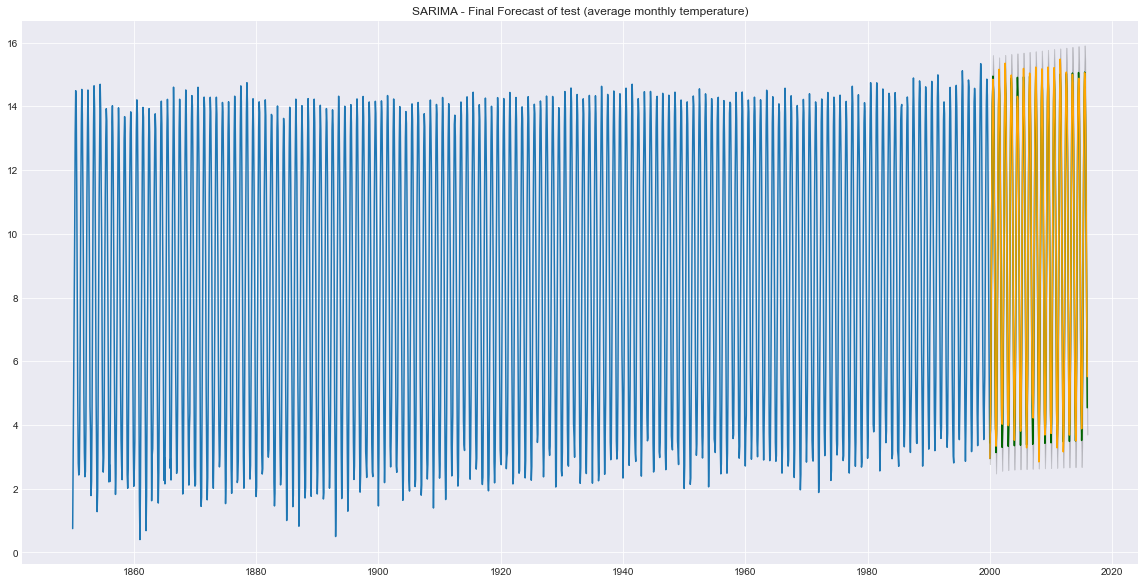

In [57]:
# Plot test results

plt.plot(train["LandAverageTemperature"])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.plot(test["LandAverageTemperature"], color='orange')
#avg_temp_year.rolling(10).mean()['LandAverageTemperature'].plot()
plt.title("SARIMA - Final Forecast of test (average monthly temperature)")
plt.show()

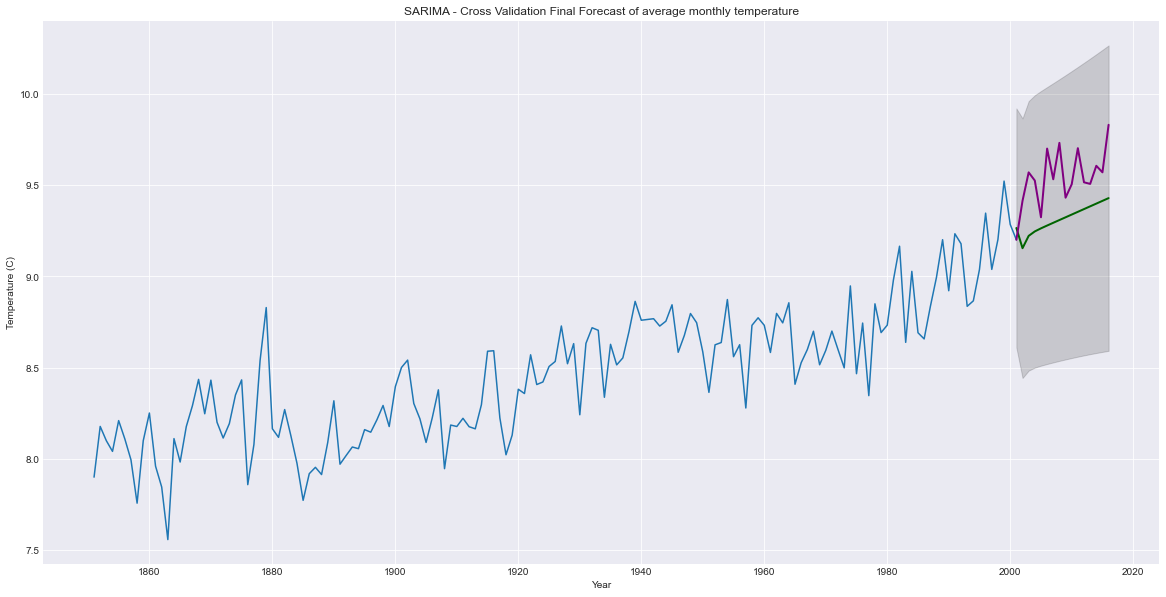

In [58]:
# Plot train dataset with 

plt.plot(train["LandAverageTemperature"].resample('Y').mean())
plt.plot(fitted_series.resample('Y').mean(), linewidth = 2.0, color='darkgreen')
plt.fill_between(lower_series.resample('Y').mean().index, 
                 lower_series.resample('Y').mean(), 
                 upper_series.resample('Y').mean(), 
                 color='k', alpha=.15)

plt.plot(test["LandAverageTemperature"].resample('Y').mean(), linewidth = 2.0, color='purple')
plt.title("SARIMA - Cross Validation Final Forecast of average monthly temperature")
plt.xlabel('Year')
plt.ylabel('Temperature (C)')
plt.show()

### 5.4 Other validation measurements

In [315]:

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE (Mean absolute percentage of error)
    me = np.mean(forecast - actual)             # ME (Margin of error)
    mae = np.mean(np.abs(forecast - actual))    # MAE (Mean Absolute Error)
    mpe = np.mean((forecast - actual)/actual)   # MPE (mean percentage Error)
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE (Root of Mean Squared Error)
    corr = np.corrcoef(forecast, actual)[0,1]   # corr (Correlation)
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]              # ACF (Autocorrelation function)
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})


In [261]:
# my model is better bitch
forecast_accuracy(test.shift(12)["LandAverageTemperature"], test["LandAverageTemperature"][0:])

{'mape': 0.05376692011067362,
 'me': -0.04198888888888886,
 'mae': 0.3413777777777777,
 'mpe': -0.003030083160093924,
 'rmse': 0.4405371720978833,
 'acf1': nan,
 'corr': nan,
 'minmax': nan}

In [316]:
# Print forecast measurements:

forecast_accuracy(fitted_series, test["LandAverageTemperature"])

#We can see that we have very low RMSE (0.38) and a very high correlation (99.7%) which indicates
   #that the model is good and pretty accurate

{'mape': 0.044885302592185615,
 'me': -0.22640547634482236,
 'mae': 0.31553932608617113,
 'mpe': -0.02594903305674312,
 'rmse': 0.3821177678159365,
 'acf1': 0.2436687760595751,
 'corr': 0.9972266009686811,
 'minmax': 0.043984486345983065}

# 6 - Forecasting until 2030

In [59]:
index_of_fc = pd.date_range(start=clean_temp.index[-12], end='2030-12', freq='MS')

In [60]:
fitted_series

2000-01-01     3.435078
2000-02-01     3.838495
2000-03-01     5.996225
2000-04-01     9.121124
2000-05-01    12.042220
                ...    
2015-08-01    14.602745
2015-09-01    12.757075
2015-10-01    10.086368
2015-11-01     6.775231
2015-12-01     4.540958
Freq: MS, Name: predicted_mean, Length: 192, dtype: float64

Text(0, 0.5, 'Temperature (C)')

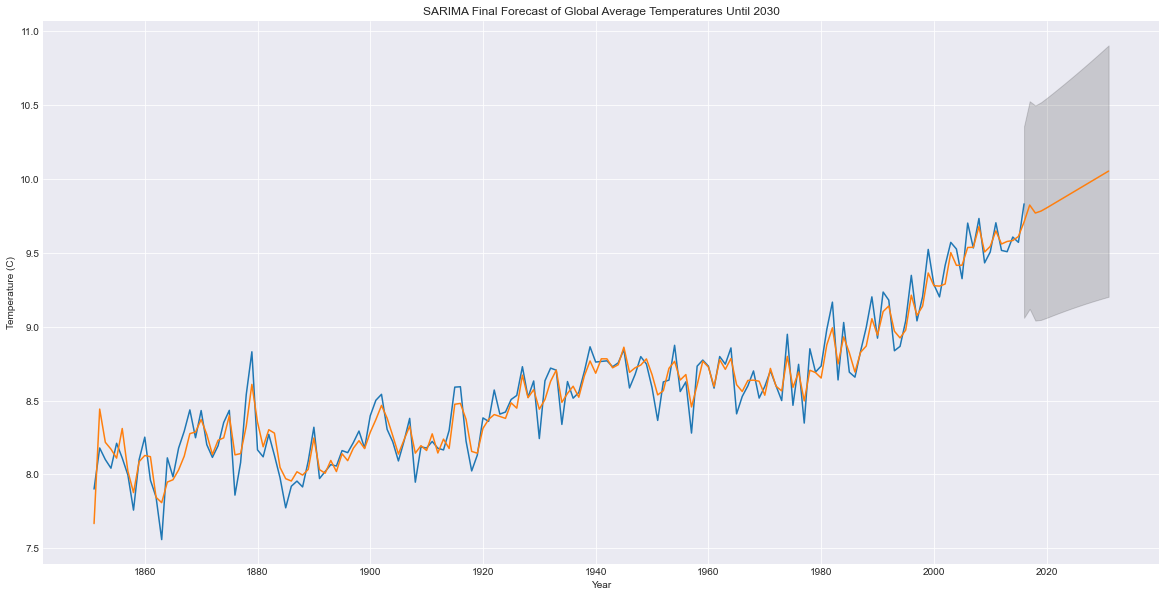

In [61]:
# Plot prediction model until year 2030:

fitted_results = fitted_model3.get_prediction(start=clean_temp.index[0], end="2030-12", dynamic=False)

# make series for plotting purpose
fitted_series = pd.Series(fitted_results.predicted_mean)
lower_series = pd.Series(fitted_results.conf_int()['lower LandAverageTemperature'], index=index_of_fc)
upper_series = pd.Series(fitted_results.conf_int()['upper LandAverageTemperature'], index=index_of_fc)

plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()
plt.fill_between(lower_series.resample('Y').mean().index, 
                 lower_series.resample('Y').mean(), 
                 upper_series.resample('Y').mean(), 
                 color='k', alpha=.15)
ax.plot(clean_temp["LandAverageTemperature"].resample('Y').mean())
ax.plot(fitted_results.predicted_mean.resample('Y').mean())
plt.title('SARIMA Final Forecast of Global Average Temperatures Until 2030')    
plt.xlabel('Year')
plt.ylabel('Temperature (C)')

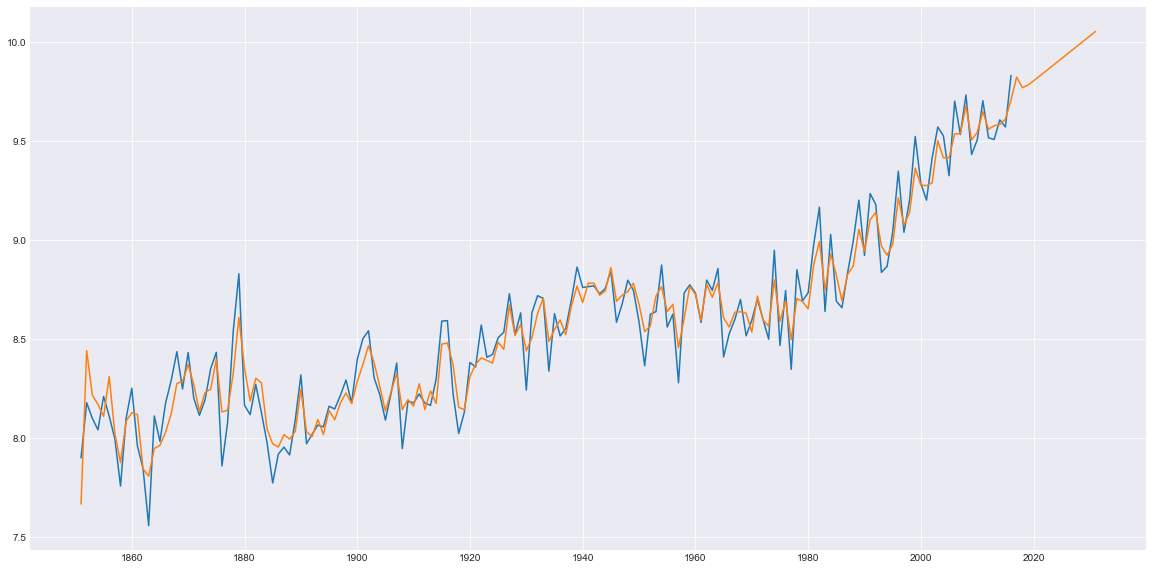

In [62]:
# Fit results resampled by year:

fitted_results = fitted_model3.get_prediction(start=clean_temp.index[0], end="2030-12", dynamic=False)

plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()
ax.plot(clean_temp["LandAverageTemperature"].resample('Y').mean())
ax.plot(fitted_results.predicted_mean.resample('Y').mean())


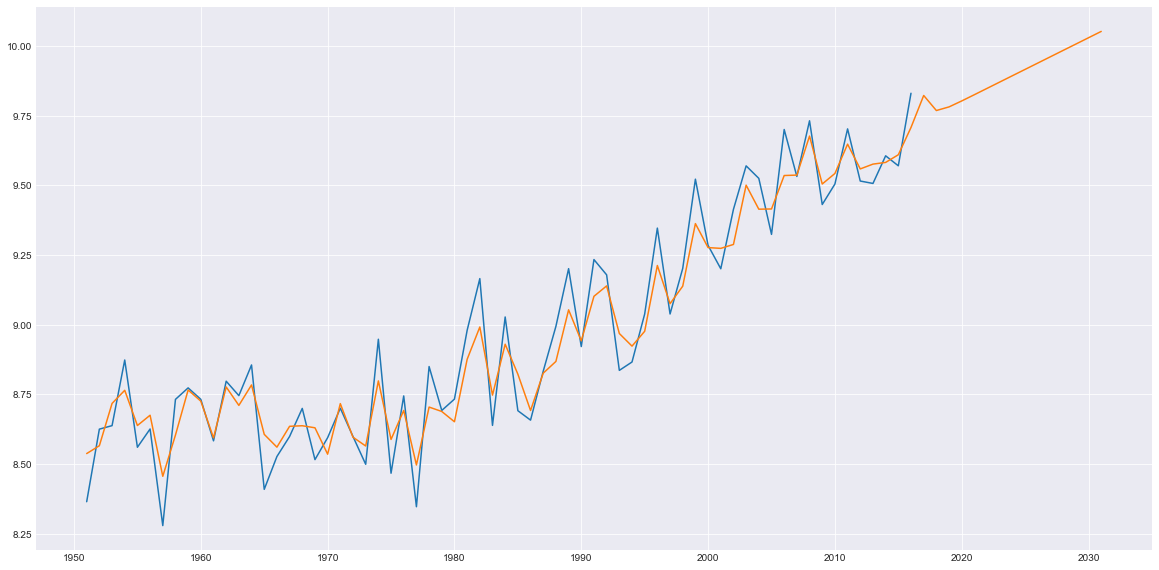

In [63]:
# 1950 -2030

fitted_results = fitted_model3.get_prediction(start=clean_temp.index[0], end="2030-12", dynamic=False)

plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()
ax.plot(clean_temp["LandAverageTemperature"].resample('Y').mean()["1950":])
ax.plot(fitted_results.predicted_mean.resample('Y').mean()["1950":])
    
    
    

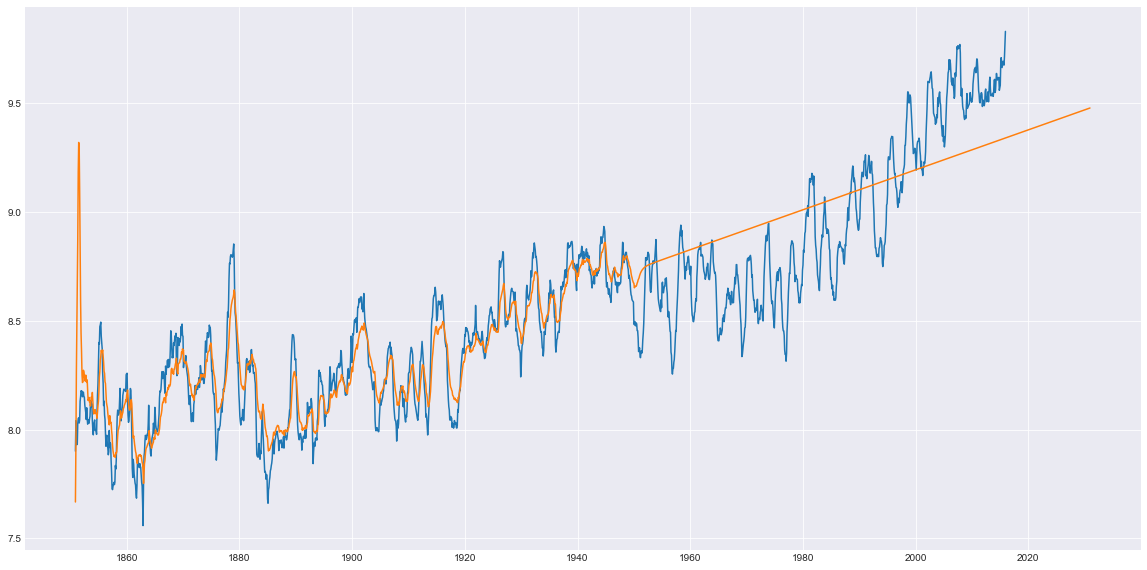

In [288]:
# This is the trend of the time series since index 1200 (from 1950)

fitted_results = fitted_model3.get_prediction(start=clean_temp.index[0], end="2030-12", dynamic=1200)

plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()
ax.plot(clean_temp["LandAverageTemperature"].rolling(12).mean() )
ax.plot(fitted_results.predicted_mean.rolling(12).mean())    
    